# ICV Assignment 4 Source Code
## 2016-17755 Wonjun lee

In [34]:
#Module import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import glob
import math
from mpl_toolkits.mplot3d import axes3d
from itertools import product
import json 
from tqdm import trange, notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from skimage.feature import hog
from sklearn.metrics import auc
import pandas as pd
import ipywidgets as widgets
from IPython.display import clear_output
import time
import pickle
import warnings

# Section 1. Linear SVM with HOG Descriptor

## 1 - a) Image Reading and preprocessing 

In [2]:
# Reading Annotation Json
with open('Self Driving Car.v3-fixed-small.coco/export/_annotations.coco.json', 'r') as f:
    json_data = json.load(f)

# Image Parse (len: 29800)
img_name = [] #Image Parse
img_id = np.zeros((len(json_data['images']))) #Image Parse

# Annotation Parse (len: 194539)
ann_img = np.zeros((len(json_data['annotations']))) #image id 
ann_cat = np.zeros((len(json_data['annotations']))) #Annotation Parse
ann_bbox = np.zeros((len(json_data['annotations']), 4)) #Annotation parsing (xmin, ymin. xmax. ymax)

#Annotation Parsing 
for i in range(len(json_data['images'])):
    img_id[i] = json_data['images'][i]['id']
    img_name.append(json_data['images'][i]['file_name'])

for i in range(len(json_data['annotations'])):
    ann_img[i] = json_data['annotations'][i]['image_id']
    ann_cat[i] = json_data['annotations'][i]['category_id']
    ann_bbox[i:] = json_data['annotations'][i]['bbox']
    

In [3]:
#SELECTING windows for training

winSize = (32,32)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 0.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = True

#Hog Descriptor defining 
descriptor = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection)

In [4]:
#Functions for further data generation
def positive_area_search(bbox, k = 5, iou_thresh =0.6):
    '''
    Input: 1D array of bounding box (xmin, ymin. xmax. ymax)
    Output: [k,4] array of postivie samples around given b-box (>iou) 
    '''
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    
    iou = np.zeros((k))
    while (np.any(iou<iou_thresh)):
        x_disp = np.random.randint(-min(round(w/2), bbox[0]-0), min(round(w/2), 511-bbox[2]), size=k)
        y_disp = np.random.randint(-min(round(h/2), bbox[1]-0), min(round(h/2), 511-bbox[3]), size=k)
        iou = (w-abs(x_disp))*(h-abs(y_disp))/(2*w*h - (w-abs(x_disp))*(h-abs(y_disp)))
    
    pos_output = np.tile(bbox, (k,1))
    pos_output[:,0] += x_disp
    pos_output[:,2] += x_disp
    pos_output[:,1] += y_disp
    pos_output[:,3] += y_disp 

    return pos_output

def negative_sampler(vehicle, winSize, k = 10):
    '''
    Input: [NX4] array of vehicle's bounding box (xmin, ymin. xmax. ymax)
    Output: [kX4] array of negative sample's bounding box 
    '''
    cmp = np.full((k), False)
    iter_num = 0 
    while (not np.all(cmp==True)): 
        x_min = np.random.randint(0, 511-winSize[0], size=k) #subtract the window size
        y_min = np.random.randint(0, 511-winSize[1], size=k)
        x_max = x_min+winSize[0]
        y_max = y_min+winSize[1]
        tmp_xy = np.vstack((x_min, y_min, x_max, y_max)).T #[k, 4]
        
        cmp = np.full((k), True)
        for ind in range(vehicle.shape[0]):
            tmp_cmp = ((x_max<vehicle[ind, 0])+(x_min>vehicle[ind,2]))+((y_max<vehicle[ind, 1])+(y_min>vehicle[ind,3]))
            cmp = cmp*tmp_cmp   
        
        iter_num +=1
        if (iter_num>25000):
            k = np.floor(k/2).astype(int)
    return tmp_xy

### Image Selection for ground truth

Ground Truth 데이터들 중 학습에 사용할 수 있는 좋은 데이터만을 선별합니다. 

In [89]:
def Save_button_clicked(b):
    global curr_img_ind
    global positive_img_ind
    with output:
        positive_img_ind.append(curr_img_ind)
        curr_img_ind = curr_img_ind + 1
        tmp_img_ind = int(img_id[curr_img_ind])
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[tmp_img_ind])), cv2.COLOR_BGR2RGB)
        tmp_bbox = ann_bbox[(ann_img==tmp_img_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
        tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
        tmp_bbox = tmp_bbox.astype(int)
        for i in range(tmp_bbox.shape[0]):
            cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 
        clear_output(wait=True)
        plt.figure(figsize=(10,10))
        plt.imshow(tmp_img)
        plt.title('Ground Truth')
        plt.axis('off') 
        plt.show()

def Pass_button_clicked(b):
    global curr_img_ind
    global positive_img_ind
    with output:
        curr_img_ind = curr_img_ind + 1
        tmp_img_ind = int(img_id[curr_img_ind])
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[tmp_img_ind])), cv2.COLOR_BGR2RGB)
        tmp_bbox = ann_bbox[(ann_img==tmp_img_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
        tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
        tmp_bbox = tmp_bbox.astype(int)
        for i in range(tmp_bbox.shape[0]):
            cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 
        clear_output(wait=True)
        plt.figure(figsize=(10,10))
        plt.imshow(tmp_img)
        plt.title('Ground Truth')
        plt.axis('off') 
        plt.show()        

def Abort_button_clicked(b):
    global abort_signal
    with output:
        abort_signal = True

    
button_save = widgets.Button(description = "Save")
button_save.on_click(Save_button_clicked)
button_pass = widgets.Button(description = 'Pass')
button_pass.on_click(Pass_button_clicked)
button_abort = widgets.Button(description = 'Abort')
button_abort.on_click(Abort_button_clicked)
output = widgets.Output()

Button(description='Save', style=ButtonStyle())

Button(description='Pass', style=ButtonStyle())

Button(description='Abort', style=ButtonStyle())

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 720x720 with 1 Axes>', 'i…

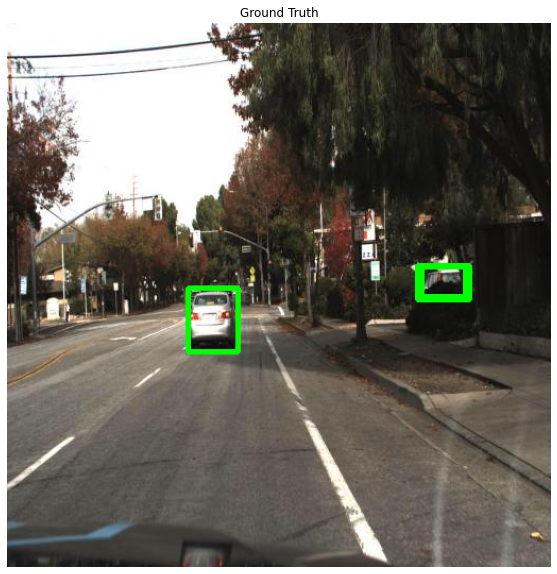

In [93]:
global abort_signal
global curr_img_ind
global positive_img_ind

abort_signal = False 
curr_img_ind = 1094
positive_img_ind = []
tmp_img_ind = int(img_id[curr_img_ind])
tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[tmp_img_ind])), cv2.COLOR_BGR2RGB)
tmp_bbox = ann_bbox[(ann_img==tmp_img_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
tmp_bbox = tmp_bbox.astype(int)
for i in range(tmp_bbox.shape[0]):
    cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 
plt.figure(figsize=(10,10))
plt.imshow(tmp_img)
plt.title('Ground Truth')
plt.axis('off') 


display(button_save, button_pass, button_abort,output)


In [ ]:
# Saving intermediate value
#intermediate_img_ind = curr_img_ind
#intermediate_img_batch = positive_img_ind.copy()
#print(intermediate_img_ind)
#print(len(intermediate_img_batch))

In [5]:
# Save or Load selected datas 

#with open("pickle/pos_list.pickle","wb") as f:
#    pickle.dump(intermediate_img_batch, f, pickle.HIGHEST_PROTOCOL)

with open("pickle/pos_list.pickle","rb") as f:
    intermediate_img_batch = pickle.load(f)

지정된 이미지들을 바탕으로 positive sample 및 negative sample을 설정합니다.

In [41]:
# Train data generation 

vehicle_ind = [True if x in intermediate_img_batch else False for x in ann_img ]*((ann_cat==2) +(ann_cat==11))
vehicle_img = ann_img[vehicle_ind]
vehicle_bbox = ann_bbox[vehicle_ind,:]
vehicle_bbox[:, 2:] = vehicle_bbox[:, :2] + np.round(vehicle_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
vehicle_bbox = vehicle_bbox.astype(int)

#Hog Feature Extraction 
train_pos = np.array([]).reshape(0,324) #64: 1764 / 32: 324
#train_pos_near = np.array([]).reshape(0, 324)

for i in notebook.tqdm(range(len(vehicle_bbox))):
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[int(vehicle_img[i])])), cv2.COLOR_BGR2RGB)
    tmp_vehicle = tmp_img[vehicle_bbox[i,1]:vehicle_bbox[i,3]+1, vehicle_bbox[i,0]:vehicle_bbox[i,2]+1]
    pos_vehicle = cv2.resize(tmp_vehicle, winSize)
    pos_feat = descriptor.compute(pos_vehicle)

    #Near Positive
    #tmp_pos_near = positive_area_search(vehicle_bbox[i,:], k = 4, iou_thresh =0.5)
    #pos_near_feat = np.zeros((tmp_pos_near.shape[0], pos_feat.shape[0]))
    #for i in range(tmp_pos_near.shape[0]):
    #    tmp_near = tmp_img[tmp_pos_near[i,1]:tmp_pos_near[i,3]+1,tmp_pos_near[i,0]:tmp_pos_near[i,2]+1]
    #    pos_near = cv2.resize(tmp_near, (64,64))
    #    pos_near_feat[i,:] = descriptor.compute(pos_near)
    
    train_pos = np.concatenate((train_pos, np.expand_dims(pos_feat, axis=0)), axis =0)
    #train_pos_near = np.concatenate((train_pos_near, pos_near_feat), axis =0)


  0%|          | 0/3503 [00:00<?, ?it/s]

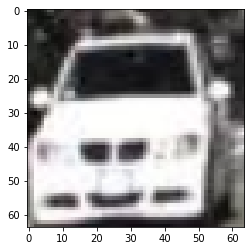

In [276]:
# Visualization of selected train patch
select = 96
vis_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[int(vehicle_img[select])])), cv2.COLOR_BGR2RGB)
vis_vehicle = vis_img[vehicle_bbox[select,1]:vehicle_bbox[select,3]+1, vehicle_bbox[select,0]:vehicle_bbox[select,2]+1]
plt.imshow(cv2.resize(vis_vehicle, (64,64)))
plt.show()

In [52]:
#Negative Sample Search - Random Selection

train_neg = np.array([]).reshape(0, 324)
for i in notebook.tqdm(range(len(img_id))):
    if (i>999):
        tmp_img_id = img_id[i]
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[i])), cv2.COLOR_BGR2RGB)
        tmp_bbox = ann_bbox[(ann_img==i)*((ann_cat==2) +(ann_cat==11))] # N*4
        tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
        tmp_bbox = tmp_bbox.astype(int)
        neg_bbox = negative_sampler(tmp_bbox, winSize, k=10)
        neg_feat = np.zeros((neg_bbox.shape[0], len(pos_feat)))
        for j in range(neg_bbox.shape[0]):
            tmp_neg = tmp_img[neg_bbox[j,1]:neg_bbox[j,3],neg_bbox[j,0]:neg_bbox[j,2]]
            tmp_neg = cv2.resize(tmp_neg, winSize)
            neg_feat[j,:]  = descriptor.compute(tmp_neg)
        
        train_neg = np.concatenate((train_neg, neg_feat), axis =0)
        
        if ((i>0) and ((i%3000)==0)) or (i==len(img_id)-1):
            with open("pickle/train_neg_iter{}.pickle".format(i),"wb") as f:
                pickle.dump(train_neg, f, pickle.HIGHEST_PROTOCOL)
            train_neg = np.array([]).reshape(0,324)

  0%|          | 0/29800 [00:00<?, ?it/s]

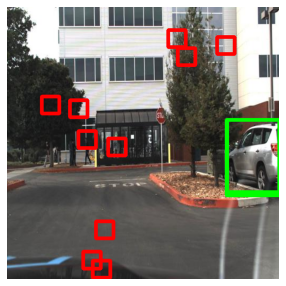

In [239]:
# Visualize selected negative patches
i=6000
if (i>1000):
        tmp_img_id = img_id[i]
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[i])), cv2.COLOR_BGR2RGB)
        tmp_bbox = ann_bbox[(ann_img==i)*((ann_cat==2) +(ann_cat==11))] # N*4
        tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
        tmp_bbox = tmp_bbox.astype(int)
        
        neg_bbox = negative_sampler(tmp_bbox, winSize = winSize,k=10)
        
        for i in range(tmp_bbox.shape[0]):
            cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 5) 

        for i in range(neg_bbox.shape[0]):
            tmp_neg = tmp_img[neg_bbox[i,1]:neg_bbox[i,3],neg_bbox[i,0]:neg_bbox[i,2]]
        #    tmp_feat = descriptor.compute(tmp_neg)
            ## winSize = (64,64), blockSize = (16,16) , blockStride = (8,8), cellSize = (8,8), nbins = 9
            #tmp_feat2 = hog(img, orientations=9, 
            #                      pixels_per_cell=(8, 8),
            #                      cells_per_block=(2, 2), 
            #                      transform_sqrt=True,
            #                      block_norm = 'L2-Hys',
            #                      multichannel 
            #                      visualise=False, feature_vector=feature_vec)
            cv2.rectangle(tmp_img, (neg_bbox[i,0], neg_bbox[i,1]), (neg_bbox[i,2]+1, neg_bbox[i,3]), (255, 0, 0), 5) 
plt.figure(figsize=(5,5))
plt.imshow(tmp_img)
plt.axis('off')
plt.show()

선정된 데이터를 pickle을 통해 저장합니다. 추후 학습때는 이를 다시 불러들여 Linear SVM을 학습시킵니다. 

In [7]:
#Saving Datas for future work 
import pickle 

#Concat iterations to create total pickle
#targetPattern = os.path.join('pickle', 'train_pos_iter*.pickle')
#filelist = glob.glob(targetPattern)
#train_pos = np.array([]).reshape(0,1764)
#for i in range(len(filelist)):
#    with open(filelist[i],"rb") as f:
#        train_pos = np.concatenate((train_pos, pickle.load(f)), axis =0)

#targetPattern = os.path.join('pickle', 'train_neg_iter*.pickle')
#filelist = glob.glob(targetPattern)
#train_neg = np.array([]).reshape(0, 324)
#for i in range(len(filelist)):
#    with open(filelist[i],"rb") as f:
#        train_neg = np.concatenate((train_neg, pickle.load(f)), axis =0)



#Save
#with open("pickle/train_pos_win32.pickle","wb") as f:
#    pickle.dump(train_pos, f, pickle.HIGHEST_PROTOCOL)
#with open("pickle/train_neg_win32.pickle","wb") as f:
#    pickle.dump(train_neg, f, pickle.HIGHEST_PROTOCOL)
#with open("pickle/train_pos_near.pickle","wb") as fw:
#    pickle.dump(train_pos_near, fw)
    
#Load 
with open("pickle/train_pos_win32.pickle","rb") as f:
    train_pos = pickle.load(f)
with open("pickle/train_neg_win32.pickle","rb") as f:
    train_neg = pickle.load(f)
#with open("train_pos_near.pickle","rb") as fw:
#    train_pos_near = pickle.load(fw)

## 1 - b) Training linear SVM

In [8]:
sample_size = len(train_pos) 

pos_feat = train_pos # Total number of 3503 features 
neg_rand_idx = np.random.randint(0, len(train_neg)-1, size = 1*sample_size)
neg_feat = train_neg[neg_rand_idx, :]

T_data = np.vstack((pos_feat, neg_feat)).astype(np.float64)                        
# Define the labels vector
T_label = np.hstack((np.ones(len(pos_feat)), np.zeros(len(neg_feat))))

# Fit a per-column scaler
T_scaler = StandardScaler().fit(T_data)

# Apply the scaler to X
T_scaled = T_scaler.transform(T_data)

# Split up data into randomized training and test sets
x_train, x_test, y_train, y_test = train_test_split(T_scaled, T_label, test_size=0.1, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(T_data, T_label, test_size=0.1, random_state=0)

# Support Vector Machine Classifier
SVM_classifier = LinearSVC(verbose=1, class_weight='balanced', max_iter=5000)
SVM_classifier.fit(x_train, y_train)

# Check the score of the SVC
print('Test Accuracy = {}'.format(round(SVM_classifier.score(x_test, y_test), 4)))

[LibLinear]Test Accuracy = 0.9544


In [190]:
# Save and load trained model 

#Save
#with open("pickle/svm_classifier.pickle","wb") as fw:
#    pickle.dump(SVM_classifier, fw) 
    
#Load 
with open("pickle/svm_classifier.pickle","rb") as f:
    SVM_classifier = pickle.load(f)

## 1 - c) Creating sliding window based pipeline

In [9]:
def SlidingWindow(img, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1):
    '''
    Code that returns the list of window blocks
    
    Input: predefined informations for sliding window 
    Output: [NX4] matrix of selected image window patches in the order of (x_min, y_min, x_max, y_max)  
    '''
    
    imshape = img.shape
    scaled_img = cv2.resize(img.copy(), (int(imshape[1]/scale), int(imshape[0]/scale)))
    
    #Searching Region    
    x_size = scaled_img.shape[1] 
    y_size = scaled_img.shape[0]
    
    # Pixel per step
    x_step = int((1 - overlap_ratio[0])*xy_window[0])
    y_step = int((1 - overlap_ratio[1])*xy_window[1])
    
    # Number of Windows
    x_edge = int(xy_window[0]*(overlap_ratio[0]))
    y_edge = int(xy_window[1]*(overlap_ratio[1]))
    num_xwind = np.floor((x_size-x_edge)/x_step).astype(int)
    num_ywind = np.floor((y_size-y_edge)/y_step).astype(int) 
    
    window_list = np.array([]).reshape(0,4) # (xmin, ymin, xmax, ymax)
    for ys in range(num_ywind):
        for xs in range(num_xwind):
            # Calculate window position
            startx = xs*x_step
            endx = startx + xy_window[0]
            starty = ys*y_step
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list = np.concatenate((window_list, np.array([startx,starty, endx, endy]).reshape(1,4)), axis=0)
    
    #Padding edges for scaled image
    if ((x_size-x_edge)%x_step != 0):
        if ((y_size-y_edge)%y_step != 0):
            for ys in range(num_ywind):
                startx = x_size - xy_window[0]
                endx = x_size-1
                starty = ys*y_step
                endy = starty + xy_window[1]
                window_list = np.concatenate((window_list, np.array([startx,starty, endx, endy]).reshape(1,4)), axis=0)
            for xs in range(num_xwind):
                startx = xs*x_step
                endx = startx + xy_window[0]
                starty = y_size - xy_window[1]
                endy = y_size-1
                window_list = np.concatenate((window_list, np.array([startx,starty, endx, endy]).reshape(1,4)), axis=0)
            #Adding Edge square1
            window_list = np.concatenate((window_list, np.array([x_size - xy_window[0], y_size - xy_window[1], x_size-1, y_size-1]).reshape(1,4)), axis=0)
        else:
            for ys in range(num_ywind):
                startx = x_size - xy_window[0]
                endx = x_size-1
                starty = ys*y_step
                endy = starty + xy_window[1]
                window_list = np.concatenate((window_list, np.array([startx,starty, endx, endy]).reshape(1,4)), axis=0)
    else:
        if ((y_size-y_edge)%y_step != 0):
            for xs in range(num_xwind):
                startx = xs*x_step
                endx = startx + xy_window[0]
                starty = y_size - xy_window[1]
                endy = y_size-1
                window_list = np.concatenate((window_list, np.array([startx,starty, endx, endy]).reshape(1,4)), axis=0)
                                                                           
    #Rescaling to Original Size
    window_list = window_list*scale
    return window_list.astype(int)


def searchMultiscale(img, svc, scaler, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
    """
    Returns the windows where the vehicles are found on the image
    
    Input: hyperparameters of multiscale window searching 
    Output:
        wind_list = [N,4] matrix of selected window predicted as vehicle bounding box
        tot_window_num = number of searched window, later used for counting number of true negatives
    """ 
    wind_list = np.array([]).reshape(0,4)
    exp_scale = 1
    iter_num = 0 
    tot_window_num = 0
    while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
        windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
        # (xmin, ymin, xmax, ymax)
        tot_window_num += windows.shape[0]
        for ind in range(windows.shape[0]):
            img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (32, 32)) #CHANGE !
            tmp_feat = descriptor.compute(img_window)
            scaled_feat = scaler.transform(tmp_feat.reshape(1, -1))
            pred = svc.predict(scaled_feat)
            if pred == 1:
                wind_list = np.concatenate((wind_list, windows[ind,:].reshape(1,4)), axis=0)
        exp_scale = scale*exp_scale
        iter_num+=1
        #if (iter_num>12):
        #    return wind_list, tot_window_num
    return wind_list, tot_window_num
                                                                           
                                                                           
def NonMaxSup(windows, overlapThresh):
    """
    Non maximum suppression of searched window
    
    Input:
        windows: [N,4] matrix of selected window predicted as vehicle bounding box
        overlapThresh = suppress windows that are overlapped more that given iou threshold
    Output: suppressed window list in the size of [N,4]
    """ 
    if windows.dtype.kind == "i":
        windows = boxes.astype("float")
                                                                           
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = windows[:,0]
    y1 = windows[:,1]
    x2 = windows[:,2] 
    y2 = windows[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i) 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of overlapped bbox
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlapThresh)[0])))
        
    # return only the bounding boxes that were picked 
    return windows[pick].astype("int")

def removeOverlap(pred):
    '''
    Remove exactly overlapping prediction windows
    
    Input: [N, 4] numpy array of (xmin, ymin, xmax, ymax)
    Output: [N',4] numpy array of overlapping bounding box removed searching windows
    '''
    len_pred = pred.shape[0]
    len_new_pred = pred.shape[0]-1
    while (len_new_pred != len_pred):
        len_pred = len_new_pred
        for i in range(pred.shape[0]):    
            x_min_bool = pred[:, 0] <= pred[i,0]
            y_min_bool = pred[:, 1] <= pred[i,1]
            x_max_bool = pred[:, 2] >= pred[i,2]
            y_max_bool = pred[:, 3] >= pred[i,3]
            larger = x_min_bool*y_min_bool*x_max_bool*y_max_bool
            larger[i] = False
            if np.any(larger == True):
                pred = np.delete(pred, i, axis = 0)
                break
        len_new_pred = pred.shape[0]
    return pred

## 1 - d) Testing detector on the test dataset 

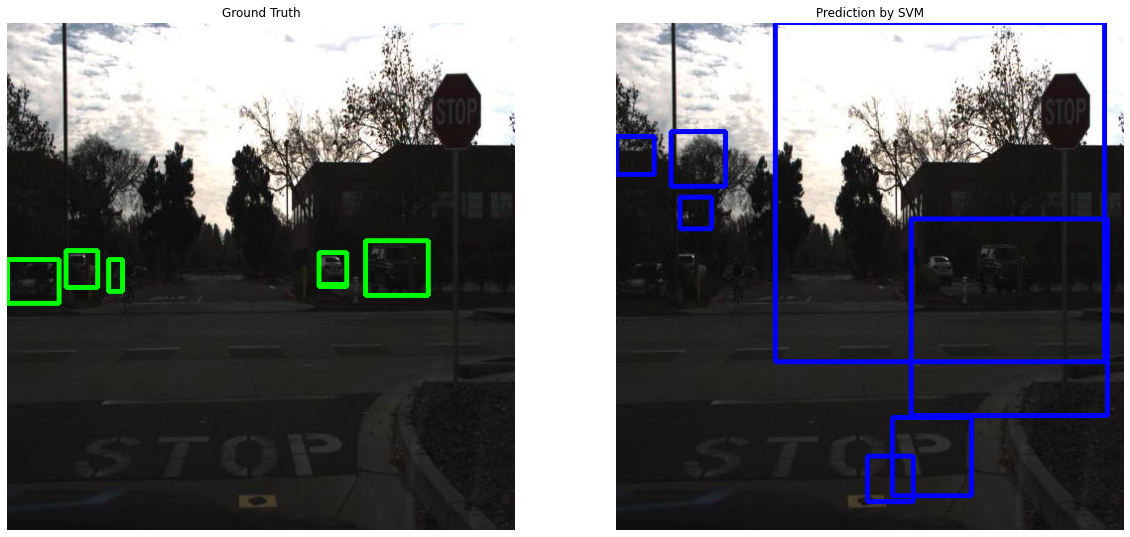

In [191]:
#Sample Visualization 

test_ind = 129# Use number between 0 to 999

tmp_img_id = img_id[test_ind]
tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[test_ind])), cv2.COLOR_BGR2RGB)
tmp_img2 = tmp_img.copy()
tmp_bbox = ann_bbox[(ann_img==test_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
tmp_bbox = tmp_bbox.astype(int)
            
for i in range(tmp_bbox.shape[0]):
    cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 

pred_wind, tot_window_num = searchMultiscale(tmp_img, SVM_classifier, T_scaler, xy_window=(32,32), overlap_ratio=(0.5, 0.5), scale = 1.2)
pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.3) #0.3~0.5
pred_wind = removeOverlap(pred_wind)
for i in range(pred_wind.shape[0]):
    cv2.rectangle(tmp_img2, (pred_wind[i,0], pred_wind[i,1]), (pred_wind[i,2], pred_wind[i,3]), (0, 0, 255), 4) 


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(tmp_img)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(122), plt.imshow(tmp_img2)
plt.title('Prediction by SVM')
plt.axis('off')

plt.show()

## 1 - e) Performance Evaluation

In [168]:
# Evaluation
precision = []
recall = []
sensitivity = []
specificity = []
iou_matrix = []
Pred_iou = np.array([])
FP_img_lst = np.array([])

for val_ind in notebook.tqdm(range(0, 1000)):
    #Ground truth generation
    tmp_img_id = img_id[val_ind] 
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[val_ind])), cv2.COLOR_BGR2RGB)
    tmp_bbox = ann_bbox[(ann_img==val_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
    tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
    tmp_bbox = tmp_bbox.astype(int)
    
    #Prediction Generation
    pred_wind, tot_window_num = searchMultiscale(tmp_img, SVM_classifier, T_scaler_re, xy_window=(32,32), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) #0.3~0.5
    pred_wind = removeOverlap(pred_wind)
    
    #Evaluation
    iou_matrix.append([tot_window_num, iouMatrix(tmp_bbox, pred_wind)])
    
    #TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
    #precision.append(zero_division(TP_cnt,(TP_cnt + FP_cnt)))
    #recall.append(zero_division(TP_cnt, (TP_cnt + FN_cnt)))
    #sensitivity.append(zero_division(TP_cnt,(TP_cnt + FN_cnt)))
    #specificity.append(zero_division(TN_cnt,(TN_cnt + FP_cnt)))
    #Pred_iou = np.concatenate((Pred_iou, tmp_iou), axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

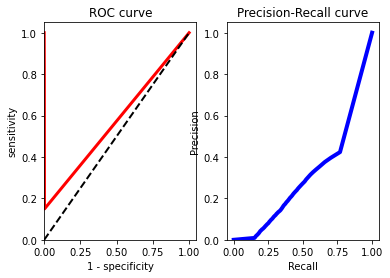

Average Precision: 31.0311%


In [169]:
# Curve Plot 
averagePrec = drawROCnPrec(iou_matrix, step = 0.01)
print("Average Precision: {}%".format(np.round(averagePrec*100,4)))

## 1 - e) Performance Evaluation (with retraining session)

In [75]:
def detectFP(ground, pred, iou_th = 0.5):
    '''
    Searching false positive image patches predicted by given classifier, later used for training 
    
    Input: [N,4] matrix of ground truth data, and prediction 
    Ouput: Number of TP, FP, and bounding boxes of FPs with each row of (xmin, ymin, xmax, ymax)
    '''
    iou = []
    FP = np.array([]).reshape(0,4)
    FP_cnt = 0
    TP_cnt = 0 
    FN_cnt = 0
    pred_detect = np.zeros((pred.shape[0])) #1 if TP, 0 if FP 
    ground_detected = np.zeros((ground.shape[0])) # 1 if detected, 0 if FN
    for i in range(pred.shape[0]):
        best_iou = 0
        for j in range(ground.shape[0]):
            xx1 = np.maximum(pred[i,0], ground[j,0])
            yy1 = np.maximum(pred[i,1], ground[j,1])
            xx2 = np.minimum(pred[i,2], ground[j,2])
            yy2 = np.minimum(pred[i,3], ground[j,3])
            overlap_area = np.maximum(0, xx2 - xx1 + 1)*np.maximum(0, yy2 - yy1 + 1)
            area_pred = np.maximum(0, pred[i,2] - pred[i,0] + 1)*np.maximum(0, pred[i,3] - pred[i,1] + 1)
            area_ground = np.maximum(0, ground[j,2] - ground[j,0] + 1)*np.maximum(0, ground[j,3] - ground[j,1] + 1)
            tmp_iou = (overlap_area)/(area_pred+area_ground-overlap_area)
            
            if (tmp_iou > iou_th):
                pred_detect[i] = 1
                ground_detected[j] = 1
            if (tmp_iou > best_iou):
                best_iou = tmp_iou
        iou.append(best_iou)
        
    TP_cnt = np.count_nonzero(pred_detect == 1)
    FP_cnt = len(pred_detect) - TP_cnt
    FN_cnt = np.count_nonzero(ground_detected == 0)            
    FP = pred[pred_detect==0]
    return TP_cnt, FP_cnt, FN_cnt, FP, np.array(iou)       

def zero_division(n, d):
    return n / d if d else 0

def zero_division2(n, d): #Returning 1
    return n / d if d else 1

def iouMatrix(ground, pred):
    '''
    Measuring intersection over unions for each ground truth and predicted bounding box, later used for drawing ROC and Precision-Recall curve
    
    Input: [N,4] matrix of ground truth data, and prediction 
    Ouput: [prediction number, ground truth number] shape of array containing iou value between each prediction box and ground truth box
    '''
    iou = np.zeros((pred.shape[0], ground.shape[0]))
    for i in range(pred.shape[0]):
        for j in range(ground.shape[0]):
            xx1 = np.maximum(pred[i,0], ground[j,0])
            yy1 = np.maximum(pred[i,1], ground[j,1])
            xx2 = np.minimum(pred[i,2], ground[j,2])
            yy2 = np.minimum(pred[i,3], ground[j,3])
            overlap_area = np.maximum(0, xx2 - xx1 + 1)*np.maximum(0, yy2 - yy1 + 1)
            area_pred = np.maximum(0, pred[i,2] - pred[i,0] + 1)*np.maximum(0, pred[i,3] - pred[i,1] + 1)
            area_ground = np.maximum(0, ground[j,2] - ground[j,0] + 1)*np.maximum(0, ground[j,3] - ground[j,1] + 1)
            iou[i,j] = (overlap_area)/(area_pred+area_ground-overlap_area)
    return iou

추출된 False positive 이미지 패치들을 기반으로 linear svm을 재학습시킵니다.

In [297]:
# Extract image patches of false positives based on currect classifier 
precision = []
recall = []
sensitivity = []
specificity = []
iou_matrix = []
FP_batch = np.array([]).reshape(0,4)
Pred_iou = np.array([])
FP_img_lst = np.array([])

for val_ind in notebook.tqdm(range(1000, len(img_id), 10)):
    #Ground truth generation
    tmp_img_id = img_id[val_ind] 
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[val_ind])), cv2.COLOR_BGR2RGB)
    tmp_bbox = ann_bbox[(ann_img==val_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
    tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
    tmp_bbox = tmp_bbox.astype(int)
    
    #Prediction Generation
    pred_wind, tot_window_num = searchMultiscale(tmp_img, SVM_classifier, T_scaler, xy_window=(32,32), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) #0.3~0.5
    
    #Evaluation
    TP_cnt, FP_cnt, FN_cnt, FP, tmp_iou = detectFP(tmp_bbox, pred_wind, iou_th = 0.5)
    iou_matrix.append([tot_window_num, iouMatrix(tmp_bbox, pred_wind)])
    
    TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
    precision.append(zero_division(TP_cnt,(TP_cnt + FP_cnt)))
    recall.append(zero_division(TP_cnt, (TP_cnt + FN_cnt)))
    sensitivity.append(zero_division(TP_cnt,(TP_cnt + FN_cnt)))
    specificity.append(zero_division(TN_cnt,(TN_cnt + FP_cnt)))
    FP_img_lst = np.concatenate((FP_img_lst, np.repeat(img_id[val_ind], FP.shape[0])), axis=0)
    FP_batch = np.concatenate((FP_batch, FP), axis=0)
    Pred_iou = np.concatenate((Pred_iou, tmp_iou), axis=0)

  0%|          | 0/2880 [00:00<?, ?it/s]

In [298]:
# Generating False positive samples
FP_batch = FP_batch.astype(int)
train_fp = np.array([]).reshape(0,324)
prev_img_ind = -1 
for i in notebook.tqdm(range(FP_batch.shape[0])):
    if (FP_img_lst[i] != prev_img_ind):        
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[int(FP_img_lst[i])])), cv2.COLOR_BGR2RGB)
        prev_img_ind = FP_img_lst[i]    

    tmp_fp = tmp_img[FP_batch[i,1]:FP_batch[i,3],FP_batch[i,0]:FP_batch[i,2]]
    fp_feat  = descriptor.compute(cv2.resize(tmp_fp, winSize))
    train_fp = np.concatenate((train_fp, fp_feat.reshape(1,-1)), axis =0)
    
    #if ((i>0) and ((i%10000)==0)) or (i==FP_batch.shape[0]-1):
    #    with open("pickle/train_fp_iter{}.pickle".format(i),"wb") as f:
    #        pickle.dump(train_fp, f, pickle.HIGHEST_PROTOCOL)
    #    train_fp = np.array([]).reshape(0,1764)

  0%|          | 0/28470 [00:00<?, ?it/s]

추출된 FP 데이터들을 pickle로 저장하고 불러옵니다. 

In [12]:
#Concat iterations to create total pickle
#targetPattern = os.path.join('pickle', 'train_fp_iter*.pickle')
#filelist = glob.glob(targetPattern)
#train_fp = np.array([]).reshape(0,1764)
#for i in range(len(filelist)):
#    with open(filelist[i],"rb") as f:
#        tmp = pickle.load(f)
#        rind =random.sample(range(tmp.shape[0]), 8000)
#        train_fp = np.concatenate((train_fp, tmp[rind]), axis =0)
        
#Save 
#with open("pickle/train_fp_win32.pickle","wb") as f:
#    pickle.dump(train_fp, f, pickle.HIGHEST_PROTOCOL)

#Load 
with open("pickle/train_fp_win32.pickle","rb") as f:
    train_fp = pickle.load(f)

불러들인 FP 데이터를 기존의 nagative data에 추가하여 Linear SVM을 재학습시킵니다. 

In [248]:
#Retrain with false positives 
sample_size = len(train_pos) #Truncation for the control of SVM weight 

#pos_rand_idx = np.random.randint(0, len(train_pos)-1, size = sample_size)
pos_feat = train_pos
neg_rand_idx = random.sample(range(len(train_neg)), 1*sample_size)
neg_feat = train_neg[neg_rand_idx, :]
fp_rand_idx = random.sample(range(len(train_fp)), 1*sample_size)
fp_feat = train_fp[fp_rand_idx, :]


T_data = np.vstack((pos_feat, neg_feat, fp_feat)).astype(np.float64)         
# Define the labels vector
T_label = np.hstack((np.ones(len(pos_feat)), np.zeros(len(neg_feat)), np.zeros(len(fp_feat))))


# Fit a per-column scaler
T_scaler_re = StandardScaler().fit(T_data)

# Apply the scaler to X
T_scaled = T_scaler_re.transform(T_data)

# Split up data into randomized training and test sets
x_train, x_test, y_train, y_test = train_test_split(T_scaled, T_label, test_size=0.1, random_state=0)

# Support Vector Machine Classifier
SVM_classifier_re = LinearSVC(verbose=1,  class_weight='balanced' ,max_iter=30000)
SVM_classifier_re.fit(x_train, y_train)

# Check the score of the SVC
print('Test Accuracy = {}'.format(round(SVM_classifier_re.score(x_test, y_test), 4)))

[LibLinear]Test Accuracy = 0.8535


In [193]:
# Save and load trained model 

#Save
#with open("pickle/svm_classifier_re.pickle","wb") as fw:
#    pickle.dump(SVM_classifier_re, fw) 
    
#Load 
with open("pickle/svm_classifier_re.pickle","rb") as f:
    SVM_classifier_re = pickle.load(f)

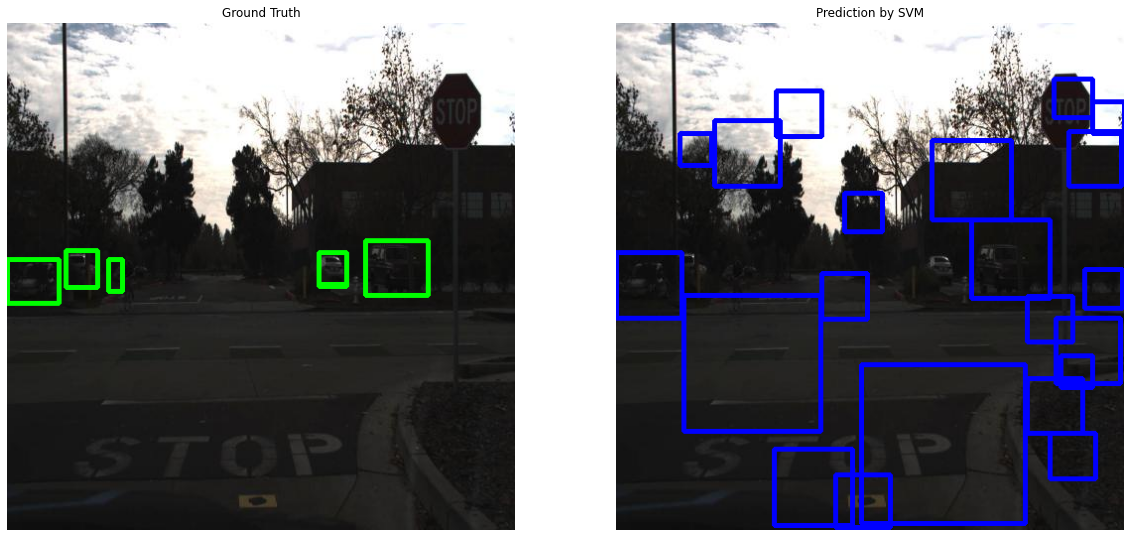

In [194]:
#Visualization
test_ind = 129 # Use number between 0 to 999, you can select any image number 

tmp_img_id = img_id[test_ind]
tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[test_ind])), cv2.COLOR_BGR2RGB)
tmp_img2 = tmp_img.copy()
tmp_bbox = ann_bbox[(ann_img==test_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
tmp_bbox = tmp_bbox.astype(int)
            
for i in range(tmp_bbox.shape[0]):
    cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 

pred_wind, tot_window_num = searchMultiscale(tmp_img, SVM_classifier_re, T_scaler_re, xy_window=(32,32), overlap_ratio=(0.5, 0.5), scale = 1.2)
pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.3) #0.3~0.5
pred_wind = removeOverlap(pred_wind)
for i in range(pred_wind.shape[0]):
    cv2.rectangle(tmp_img2, (pred_wind[i,0], pred_wind[i,1]), (pred_wind[i,2], pred_wind[i,3]), (0, 0, 255), 4) 


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(tmp_img)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(122), plt.imshow(tmp_img2)
plt.title('Prediction by SVM')
plt.axis('off')

plt.show()

In [86]:
#ROC curve 
def drawROCnPrec(iou_matrix, step = 0.01):
    '''
    Draw ROC curve and Precision-recall curve based on given iou values. Gradually increase iou_threshold and calculate value
    
    Input: [N,M] matrix containing informations of intersection over unions
    Output: plotted figure
    '''
    iou_thresh = 0
    tot_precision = []
    tot_recall = []
    tot_sensitivity = []
    tot_specificity = []
    while (iou_thresh <= 1):
        precision = []
        recall = []
        sensitivity = []
        specificity = []
        for i in range(len(iou_matrix)):
            tmp_iou = iou_matrix[i][-1] # row: pred/ col: gound numpy array

            if (tmp_iou.shape[0] == 0):
                ground_iou = np.zeros(tmp_iou.shape[1])
            else:
                ground_iou = np.max(tmp_iou, axis =0)
            
            if (tmp_iou.shape[1] == 0):
                pred_iou = np.zeros(tmp_iou.shape[0])
            else:
                pred_iou = np.max(tmp_iou, axis = 1)
            
            tot_window_num = iou_matrix[i][0]
            TP_cnt = len(pred_iou[pred_iou >= iou_thresh])
            FP_cnt = len(pred_iou) - TP_cnt
            FN_cnt = len(ground_iou[ground_iou < iou_thresh])
            TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
            precision.append(zero_division2(TP_cnt,(TP_cnt + FP_cnt)))
            recall.append(zero_division2(TP_cnt, (TP_cnt + FN_cnt)))
            sensitivity.append(zero_division2(TP_cnt, (TP_cnt + FN_cnt)))
            specificity.append(zero_division(TN_cnt, (TN_cnt + FP_cnt)))
        tot_precision.append(np.mean(precision))
        tot_recall.append(np.mean(recall))
        tot_sensitivity.append(np.mean(sensitivity))
        tot_specificity.append(np.mean(specificity))
        iou_thresh +=step 
    
    #Figure ploting
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #ROC curve
    #plt.subplot(1,2,1) 
    tot_specificity.append(0)
    tot_sensitivity.append(1)
    ax1.plot(1-np.array(tot_specificity), np.array(tot_sensitivity), color='red', linewidth=3)
    #ax1.plot([1-min(tot_specificity), 1], [tot_sensitivity[np.argmin(tot_specificity)], 1], color='red', linewidth = 3)
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    
    ax1.set_xlim([0.0, 1.05])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('1 - specificity')
    ax1.set_ylabel('sensitivity')
    ax1.set_title('ROC curve')
    #precision recall curve
    #plt.subplot(1,2,2) 
    tot_recall.append(0)
    tot_precision.append(0)
    ax2.plot(np.array(tot_recall), np.array(tot_precision), color='blue', linewidth=4)
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall curve')
    
    plt.show() 
    return auc(np.array(tot_recall), np.array(tot_precision))

In [156]:
# Evaluation
precision = []
recall = []
sensitivity = []
specificity = []
iou_matrix = []
Pred_iou = np.array([])
FP_img_lst = np.array([])

for val_ind in notebook.tqdm(range(0, 1000)):
    #Ground truth generation
    tmp_img_id = img_id[val_ind] 
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[val_ind])), cv2.COLOR_BGR2RGB)
    tmp_bbox = ann_bbox[(ann_img==val_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
    tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
    tmp_bbox = tmp_bbox.astype(int)
    
    #Prediction Generation
    pred_wind, tot_window_num = searchMultiscale(tmp_img, SVM_classifier_re, T_scaler_re, xy_window=(32,32), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) #0.3~0.5
    pred_wind = removeOverlap(pred_wind)
    
    #Evaluation
    iou_matrix.append([tot_window_num, iouMatrix(tmp_bbox, pred_wind)])
    
    #TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
    #precision.append(zero_division(TP_cnt,(TP_cnt + FP_cnt)))
    #recall.append(zero_division(TP_cnt, (TP_cnt + FN_cnt)))
    #sensitivity.append(zero_division(TP_cnt,(TP_cnt + FN_cnt)))
    #specificity.append(zero_division(TN_cnt,(TN_cnt + FP_cnt)))
    #Pred_iou = np.concatenate((Pred_iou, tmp_iou), axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

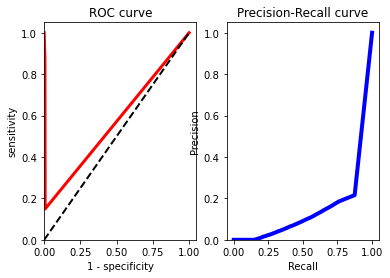

Average Precision: 14.9806%


In [158]:
# Curve Plot 
averagePrec = drawROCnPrec(iou_matrix, step = 0.01)
print("Average Precision: {}%".format(np.round(averagePrec*100,4)))

tSNE 분석을 통해 초기의 positive 및 negative sample과 False positive sample의 feature를 시각화합니다. 

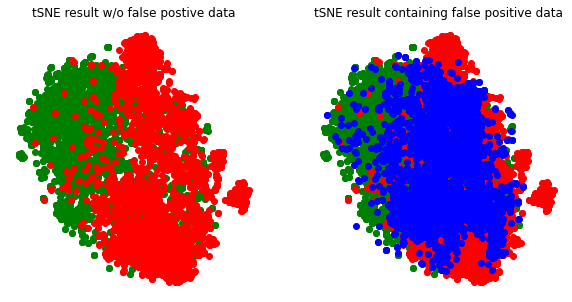

In [255]:
# tSNE Visualization result of training data 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(T_data)
tsne_label = np.hstack((np.zeros(len(pos_feat)), np.ones(len(neg_feat)), 1+np.ones(len(fp_feat)) ))

indices_n = 0, 1
indices = 0, 1, 2
colors_n = 'g', 'r'
colors = 'g', 'r', 'b'

plt.figure(figsize=(10,5))
plt.subplot(121)
for i, c in zip(indices_n, colors_n):
    plt.scatter(X_2d[tsne_label == i, 0], X_2d[tsne_label == i, 1], c=c)
plt.title('tSNE result w/o false postive data')
plt.axis('off')
plt.subplot(122)
for i, c in zip(indices, colors):
    plt.scatter(X_2d[tsne_label == i, 0], X_2d[tsne_label == i, 1], c=c)
plt.title('tSNE result containing false positive data')
plt.axis('off')

plt.show()

# Section 2. Cascaded architecture of Linear SVM with HOG Descriptor

In [18]:
def generate_total_block(windowSize = (64, 64)):
    '''
    Generate different sets of image patches on given window size. Base on calculated combination, optimal window is selected afterward 
    
    Input: window size
    Output: [N,4] matrix of different image patches in the order of (xmin, ymin, xmax, ymax)
    '''
    available_len_x = np.array([windowSize[0]/2**(i) for i in range(int(np.log2(windowSize[0])-2))])
    available_len_y = np.array([windowSize[1]/2**(i) for i in range(int(np.log2(windowSize[1])-2))])
    
    block_set = np.array([]).reshape(0,4) #xmin, ymin, xmax, ymax
    step_size = 4
    x_seed = np.arange(0, windowSize[0], step_size)
    y_seed = np.arange(0, windowSize[1], step_size)
    for i in range(len(available_len_x)):
        tmp_len_x = available_len_x[i]
        available_pair_y = available_len_y[(available_len_y/tmp_len_x >= 0.25)*(available_len_y/tmp_len_x <= 4)]
        for j in range(len(available_pair_y)):
            tmp_len_y = available_pair_y[j]
            tmp_xseeds = x_seed[x_seed <= (windowSize[0] - tmp_len_x)]
            tmp_yseeds = y_seed[y_seed <= (windowSize[1] - tmp_len_y)]
            tmp_xseeds_ = np.tile(tmp_xseeds, len(tmp_yseeds))
            tmp_yseeds_ = np.repeat(tmp_yseeds, len(tmp_xseeds))
            min_xy = np.vstack((tmp_xseeds_,  tmp_yseeds_))
            max_xy = np.vstack((tmp_xseeds_+tmp_len_x,  tmp_yseeds_+tmp_len_y))
            set_xy = np.vstack((min_xy, max_xy)).T #[N, 4]
            block_set = np.concatenate((block_set, set_xy), axis=0)
    return block_set

def calHog(block):
    '''
    Calculate hog features of given block. Divide give block into (2,2) cell
    
    Input: block image patch with varying sizes
    Output: [36,1] 1D vector containing calculated hog feature 
    '''
    feat = hog(block, orientations=9, pixels_per_cell=(block.shape[0]/2, block.shape[1]/2),
                    cells_per_block=(2, 2), visualize=False, multichannel=True)
    return feat

## 2 - a) Creating cascaded SVM with custom adaboost 

In [19]:
# Functions for updating adaboost coefficients
def compute_error(y, y_pred, w_i):
    '''
    Calculate and update the error of a weak classifier. Calibrated to improve accuracy 
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)

def compute_alpha(error):
    '''
    Compute the weight of each weak classifier, later used to update error 
    '''
    return np.log((1 - error) / error)

def update_weights(w_i, alpha, y, y_pred):
    ''' 
    Update weights of each weak classifer after 1 cascade 
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

추후 cascade의 각 level을 구성하는 adaboost classifier를 정의하는 class입니다. 

In [44]:
# Define AdaBoost class
class Cas_AdaBoost:
    def __init__(self, img_id, img_name, ann_bbox, ann_cat, ann_img):
        self.alphas = []
        self.G_M = []
        self.G_M_block = []
        self.G_M_scaler = []
        self.M = len(self.G_M) #it is not updated interactively
        self.training_errors = []
        self.prediction_errors = []
        self.block_set = generate_total_block(windowSize = (64, 64))
        
        #Values of image
        self.img_id = img_id
        self.img_name = img_name
        self.ann_bbox = ann_bbox
        self.ann_cat = ann_cat
        self.ann_img = ann_img
        
        
    def LinSVM(self, block_set, X, y, w_i, k = 70):
        '''
        block_set: [N,4] block sets
        X: [total_data_number, 64, 64, 3] patch of image
        y: rget variable - array-like vector
        k = number for 5% estimators
        '''
        rand_ind = random.sample(range(block_set.shape[0]), k)
        rand_block = block_set[rand_ind].astype(int) #[70,4] np.array 
        bst_accuracy = 0 
        bst_error = 1
        X_ind = np.arange(0,X.shape[0])
        # Split up data into randomized training and test sets
        x_train_ind, x_test_ind, y_train, y_test = train_test_split(X_ind, y, test_size=0.1, random_state=0)
        for i in range(k): 
            X_block = X[:, rand_block[i,1]:rand_block[i,3], rand_block[i,0]:rand_block[i,2], :] #[tot_num, batch_x, batch_y]
            X_hog = np.zeros((X_block.shape[0], 36))
            for j in range(X_block.shape[0]):
                X_hog[j, :] = calHog(X_block[j,:,:,:]).astype(np.float64)
            
            # Fit a per-column scaler
            tmp_scaler = StandardScaler().fit(X_hog)
                
            # Apply the scaler to X
            X_scaled = tmp_scaler.transform(X_hog) 
                
            # Support Vector Machine Classifier
            # Convergence checkpoint & LinearSVM Training
            not_converged = 1
            max_iter_n = 15000
            with warnings.catch_warnings():
                warnings.filterwarnings('error')
                while (not_converged):
                    try:
                        tmp_svm = LinearSVC(max_iter=max_iter_n)
                        #tmp_svm.fit(X_scaled[x_train_ind], y_train)
                        tmp_svm.fit(X_scaled, y, sample_weight=w_i)
                        #tmp_svm.fit(X_scaled, y)
                        not_converged = 0
                    except Warning:
                        max_iter_n = max_iter_n*2
                    
                    # Break if iteration number is too large
                    if (max_iter_n > 15000000):
                        tmp_svm = LinearSVC(max_iter=max_iter_n)
                        tmp_svm.fit(X_scaled, y, sample_weight=w_i)
                        not_converged = 0
            
            #tmp_svm_accuracy = round(tmp_svm.score(X_scaled[x_test_ind], y_test), 4)
            tmp_svm_predict = tmp_svm.predict(X_scaled)
            tmp_svm_error = compute_error(y, tmp_svm_predict, w_i)
            
            #if (tmp_svm_accuracy > bst_accuracy):
            if (tmp_svm_error < bst_error):
                bst_svm = tmp_svm
                bst_block = rand_block[i,:]
                bst_pred = tmp_svm_predict
                bst_scaler = tmp_scaler
                #bst_accuracy = tmp_svm_accuracy
                bst_ind = rand_ind[i]
                bst_error = tmp_svm_error
        self.block_set = np.delete(self.block_set, bst_ind, axis = 0)
        return bst_svm, bst_block, bst_pred, bst_scaler
    
    def searchMultiscale2(self, img, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
        """
        Returns the windows where the vehicles are found on the image
        """ 
        wind_list = np.array([]).reshape(0,4)
        exp_scale = 1
        iter_num = 0 
        tot_window_num = 0
        while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
            windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
            # (xmin, ymin, xmax, ymax)
            tot_window_num += windows.shape[0]
            tmp_tot_img_window = np.array([]).reshape(0,64, 64, 3) 
            for ind in range(windows.shape[0]):
                img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (64, 64)) #CHANGE !
                tmp_tot_img_window = np.concatenate((tmp_tot_img_window, np.expand_dims(img_window, axis = 0)), axis = 0)
            
            pred = self.predict(tmp_tot_img_window)
            if np.any(pred == 1):
                wind_list = np.concatenate((wind_list, windows[pred == 1]), axis=0)
    
            exp_scale = scale*exp_scale
            iter_num+=1
            if (iter_num>3):
                return wind_list, tot_window_num
        return wind_list, tot_window_num
    
    
    def updateF(self):
        '''
         calculate false detection rate FP/(TP+FP)
        '''
        false_detection = []
    
        #Select 500 random images to check model's false detection rate  
        random_val_ind = random.sample(range(1000, len(self.img_id)), 4)
        for val_ind in random_val_ind:
            #Ground truth generation
            tmp_img_id = self.img_id[val_ind] 
            tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',self.img_name[val_ind])), cv2.COLOR_BGR2RGB)
            tmp_bbox = self.ann_bbox[(self.ann_img==val_ind)*((self.ann_cat==2) +(self.ann_cat==11))] # N*4
            tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
            tmp_bbox = tmp_bbox.astype(int)
            
            #Prediction Generation
            pred_wind, tot_window_num = self.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
            pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) #0.3~0.5
            pred_wind = removeOverlap(pred_wind)
            
            #Evaluation
            TP_cnt, FP_cnt, FN_cnt, FP, tmp_iou = detectFP(tmp_bbox, pred_wind, iou_th = 0.5)
            false_detection.append(zero_division(FP_cnt, (TP_cnt + FP_cnt)))

        fd_rate  = np.mean(false_detection)
        return fd_rate
    
    def trainAcc(self, X, y):

        # Calculate final predictions
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y)/len(y)
        return accuracy
    
    def fit(self, X, y, target_Acc):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        f_max: predefined false discovery rate (instead of false-positive rate)
        '''
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        curr_f = 1.0 # FP/(TP+FP)
        m = 0
        curr_Acc = 0
        Acc_history = []
        # Iterate over M weak classifiers
        #while (curr_f > f_max):
        while (curr_Acc < target_Acc):
            print("Training {}_th weak classifier, current train accuracy: {}".format(m, round(curr_Acc, 4)), end='')
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            G_m, G_block, y_pred, G_scaler = self.LinSVM(self.block_set, X, y, w_i, k = 70)
            
            self.G_M.append(G_m) # Save to list of weak classifiers
            self.G_M_block.append(G_block)
            self.G_M_scaler.append(G_scaler)
            
            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            
            # update threshold values
            curr_Acc = self.trainAcc(X, y)
            if ((curr_Acc > 0.985) or (curr_Acc > target_Acc)):
                curr_f = self.updateF()
                print(", False detection rate: {}".format(round(curr_f, 4)))
            else:
                print("")
            m = m + 1 
            
            #If learning is saturated go to next cascade layer 
            Acc_history.append(curr_Acc)
            if ((len(Acc_history) > 30) and ((max(Acc_history)-min(Acc_history))<0.00005)):
                break
        assert len(self.G_M) == len(self.alphas)
        print("Cascade Generated!")
        return curr_Acc, curr_f
        
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like (k image sets)
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(len(self.G_M))) 
        
        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(len(self.G_M)):             
            tmp_block = self.G_M_block[m]
            tmp_scaler = self.G_M_scaler[m]
            
            X_block = X[:, tmp_block[1]:tmp_block[3], tmp_block[0]:tmp_block[2], :] #[tot_num, batch_x, batch_y]
            X_hog = np.zeros((X_block.shape[0], 36))
            for j in range(X_block.shape[0]):
                X_hog[j, :] = calHog(X_block[j,:,:,:]).astype(np.float64)
                
            # Apply the scaler to X
            X_scaled = tmp_scaler.transform(X_hog) 
            y_pred_m = self.G_M[m].predict(X_scaled) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
            
        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred

cascade architecture의 학습을 위한 데이터를 생성합니다. 이때 데이터는 전과 마찬가지로 선정된 feature 만을 이용합니다. 

In [363]:
# Initial training data generation (This time based on image patch of (64, 64))

#POSITIVE DATA GENERATION
vehicle_ind = [True if x in intermediate_img_batch else False for x in ann_img ]*((ann_cat==2) +(ann_cat==11))
vehicle_img = ann_img[vehicle_ind]
vehicle_bbox = ann_bbox[vehicle_ind,:]
vehicle_bbox[:, 2:] = vehicle_bbox[:, :2] + np.round(vehicle_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
vehicle_bbox = vehicle_bbox.astype(int)

#Hog Feature Extraction 
train_pos_patch = np.array([]).reshape(0, 64, 64, 3) 

for i in notebook.tqdm(range(len(vehicle_bbox))):
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[int(vehicle_img[i])])), cv2.COLOR_BGR2RGB)
    tmp_vehicle = tmp_img[vehicle_bbox[i,1]:vehicle_bbox[i,3]+1, vehicle_bbox[i,0]:vehicle_bbox[i,2]+1]
    pos_vehicle = cv2.resize(tmp_vehicle, (64,64))
    
    train_pos_patch = np.concatenate((train_pos_patch,  np.expand_dims(pos_vehicle, axis = 0)), axis =0)
   
    
#NEGATIVE DATA GENERATION 
train_neg_patch = np.array([]).reshape(0, 64, 64, 3)
for i in notebook.tqdm(range(len(img_id))):
    if (i>999):
        tmp_img_id = img_id[i]
        tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[i])), cv2.COLOR_BGR2RGB)
        tmp_bbox = ann_bbox[(ann_img==i)*((ann_cat==2) +(ann_cat==11))] # N*4
        tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
        tmp_bbox = tmp_bbox.astype(int)
        neg_bbox = negative_sampler(tmp_bbox, (64,64), k=5)
        for j in range(neg_bbox.shape[0]):
            tmp_neg = tmp_img[neg_bbox[j,1]:neg_bbox[j,3],neg_bbox[j,0]:neg_bbox[j,2]]
            tmp_neg = cv2.resize(tmp_neg, (64,64))
            train_neg_patch = np.concatenate((train_neg_patch,  np.expand_dims(tmp_neg, axis = 0)), axis =0)
        
        if (((i%3000)==0) or (i==len(img_id)-1)):
            with open("pickle/train_neg_cascade_(64,64)_iter{}.pickle".format(i),"wb") as f:
                pickle.dump(train_neg_patch, f, pickle.HIGHEST_PROTOCOL)
            train_neg_patch = np.array([]).reshape(0, 64, 64, 3)

  0%|          | 0/3503 [00:00<?, ?it/s]

  0%|          | 0/29800 [00:00<?, ?it/s]

생성된 데이터를 pickle의 형태로 저장하고 불러옵니다. 불러온 데이터는 추후 학습에 이용됩니다. 

In [23]:
#targetPattern = os.path.join('pickle', 'train_neg_cascade_(64,64)_iter*.pickle')
#filelist = glob.glob(targetPattern)
#train_neg_patch = np.array([]).reshape(0, 64, 64, 3)
#for i in range(len(filelist)):
#    with open(filelist[i],"rb") as f:
#        tmp = pickle.load(f)
#        rind =random.sample(range(tmp.shape[0]), 3000)
#        train_neg_patch = np.concatenate((train_neg_patch, tmp[rind]), axis =0)

#with open("pickle/train_pos_cascade_(64,64).pickle","wb") as f:
#    pickle.dump(train_pos_patch, f, pickle.HIGHEST_PROTOCOL)
#with open("pickle/train_neg_cascade_(64,64).pickle","wb") as f:
#    pickle.dump(train_neg_patch, f, pickle.HIGHEST_PROTOCOL)

with open("pickle/train_pos_cascade_(64,64).pickle","rb") as f:
    train_pos_patch = pickle.load(f)
with open("pickle/train_neg_cascade_(64,64).pickle","rb") as f:
    train_neg_patch = pickle.load(f)

In [24]:
sample_size = train_pos_patch.shape[0] #Truncation for the control of SVM weight 

pos_batch = train_pos_patch
neg_rand_idx = random.sample(range(len(train_neg_patch)), 1*sample_size)
neg_batch = train_neg_patch[neg_rand_idx, :]

T_data = np.concatenate((pos_batch, neg_batch), axis =0).astype(np.float64)        
T_label = np.hstack((np.ones(pos_batch.shape[0]), -np.ones(neg_batch.shape[0])))

제작한 adaboost가 잘 작동하는지 확인합니다. Training accuracy가 점진적으로 상승하는 것을 통해 adaboost 알고리즘이 잘 구현되었음을 알 수 있습니다. 

In [536]:
#Generate single adaboost layer 
cascade_1 = Cas_AdaBoost(img_id, img_name, ann_bbox, ann_cat, ann_img)
cas_acc, cas_f = cascade_1.fit(T_data, T_label, target_Acc=0.99)

Training 0_th weak classifier, current train accuracy: 0, FP rate: 1.0
Training 1_th weak classifier, current train accuracy: 0.8694, FP rate: 0.9947916666666666
Training 2_th weak classifier, current train accuracy: 0.8694, FP rate: 0.9833877995642701
Training 3_th weak classifier, current train accuracy: 0.9318, FP rate: 0.9784219703574543
Training 4_th weak classifier, current train accuracy: 0.9318, FP rate: 0.9803030303030303
Training 5_th weak classifier, current train accuracy: 0.9508, FP rate: 0.9699820788530467
Training 6_th weak classifier, current train accuracy: 0.944, FP rate: 0.9926470588235294
Training 7_th weak classifier, current train accuracy: 0.9509, FP rate: 1.0
Training 8_th weak classifier, current train accuracy: 0.9543, FP rate: 1.0
Training 9_th weak classifier, current train accuracy: 0.9569, FP rate: 1.0
Training 10_th weak classifier, current train accuracy: 0.96, FP rate: 0.9813179347826086
Training 11_th weak classifier, current train accuracy: 0.9619, FP

0.9222222222222223

Adaboot를 cascade시킨 cascade pipeline입니다. 학습은 false positive rate이 hyper parameter로 주어진 값을 도달했을 대 멈추도록 합니다. 각 casacade는 주어진 정확도를 달성했을 때 다음 cascade로 넘어가 새로운 weak classifier를 학습시킵니다.

In [152]:
# Generating Total cascade pipeline 
class Casade_pipeline:
    def __init__(self, img_id, img_name, ann_bbox, ann_cat, ann_img):
        self.cascade = []
        self.level = len(self.cascade)
        
        #Values of image
        self.img_id = img_id
        self.img_name = img_name
        self.ann_bbox = ann_bbox
        self.ann_cat = ann_cat
        self.ann_img = ann_img
    
    def searchMultiscale2(self, img, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
        """
        Returns the windows where the vehicles are found on the image
        """ 
        wind_list = np.array([]).reshape(0,4)
        exp_scale = 1
        iter_num = 0 
        tot_window_num = 0
        while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
            windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
            # (xmin, ymin, xmax, ymax)
            tot_window_num += windows.shape[0]
            tmp_tot_img_window = np.array([]).reshape(0,64, 64, 3) 
            for ind in range(windows.shape[0]):
                img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (64, 64)) #CHANGE !
                tmp_tot_img_window = np.concatenate((tmp_tot_img_window, np.expand_dims(img_window, axis = 0)), axis = 0)
            
            pred = self.predict(tmp_tot_img_window)     
            if np.any(pred==1):
                wind_list = np.concatenate((wind_list, windows[pred == 1]), axis=0)
            
            exp_scale = scale*exp_scale
            iter_num+=1
            if (iter_num>4):
                return wind_list, tot_window_num
        return wind_list, tot_window_num
    
    def updateNeg(self, num_positive):
        '''
         Get new Negative datasets for training
        '''
        
        train_neg_patch = np.array([]).reshape(0, 64, 64, 3)
        
        #Select 500 random images to check model's false detection rate  
        random_val_ind = random.sample(range(1000, len(self.img_id)), 3000)
        for val_ind in random_val_ind:
            #Ground truth generation
            tmp_img_id = self.img_id[val_ind] 
            tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',self.img_name[val_ind])), cv2.COLOR_BGR2RGB)
            tmp_bbox = self.ann_bbox[(self.ann_img==val_ind)*((self.ann_cat==2) +(self.ann_cat==11))] # N*4
            tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
            tmp_bbox = tmp_bbox.astype(int)
            
            #Prediction Generation
            pred_wind, tot_window_num = self.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
            pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.9) # just for fp data generation
            
            #Evaluation
            TP_cnt, FP_cnt, FN_cnt, FP, tmp_iou = detectFP(tmp_bbox, pred_wind, iou_th = 0.5)
            
            for i in range(FP.shape[0]):
                tmp_fp = cv2.resize(tmp_img[FP[i,1]:FP[i,3],FP[i,0]:FP[i,2]], (64,64))
                train_neg_patch = np.concatenate((train_neg_patch, np.expand_dims(tmp_fp, axis=0)), axis=0)
                if (train_neg_patch.shape[0] >= 1*num_positive): #################################################바꿔 필요시
                    return train_neg_patch
        return train_neg_patch
    
    def fit(self, X_pos, y_pos, X_neg, y_neg, target_Acc = 0.98, F_target = 0.5, accDecay = 0.98):
        F_curr = 1.0
        X = np.concatenate((X_pos, X_neg), axis =0).astype(np.float64)        
        y = np.hstack((np.ones(X_pos.shape[0]), -np.ones(X_neg.shape[0])))
        cascade_level = 0
        level_target_acc = target_Acc
        
        while (F_curr > F_target):
            print("*******Current cascade level: {} / Expected false detection rate : {}".format(cascade_level, round(F_curr,4)))
            tmp_cascade = Cas_AdaBoost(self.img_id, self.img_name, self.ann_bbox, self.ann_cat, self.ann_img)
            curr_Acc, curr_f = tmp_cascade.fit(X, y, target_Acc = level_target_acc)
            self.cascade.append(tmp_cascade)
            
            # Making new negative dataset for next cascade
            X_neg = self.updateNeg(X_pos.shape[0])
            X = np.concatenate((X_pos, X_neg), axis =0).astype(np.float64)        
            y = np.hstack((np.ones(X_pos.shape[0]), -np.ones(X_neg.shape[0])))
            
            # Updating False detection rate 
            F_curr = F_curr*curr_f
            cascade_level +=1
            level_target_acc = level_target_acc*accDecay
            
        print('Training Done !!')
    
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like (k image sets - 4 Dimensional image sets)
        '''
        # Predict class label for each weak classifier, weighted by alpha_m
        final_cas_predict = np.ones(X.shape[0])
        X_casind = np.argwhere(final_cas_predict==1).ravel()
        X_origin = X.copy()
        for lv in range(len(self.cascade)):
            curr_cascade = self.cascade[lv]
            curr_predict = curr_cascade.predict(X) # [N] +1 or -1 // 이미 짧아진 것 
            tmp_curr_predict = -np.ones(len(final_cas_predict))
            tmp_curr_predict[X_casind] = curr_predict
            
            #final_cas_predict = np.min(np.vstack((final_cas_predict, tmp_curr_predict)), axis =0) 
            final_cas_predict = tmp_curr_predict
            if np.all(final_cas_predict == -1):
                return final_cas_predict
            
            #update X 
            X_casind = np.argwhere(final_cas_predict==1).ravel()
            X = X_origin[X_casind]

        
        return final_cas_predict

In [51]:
CASCADE_DETECTOR = Casade_pipeline(img_id, img_name, ann_bbox, ann_cat, ann_img)
CASCADE_DETECTOR.fit(X_pos = pos_batch, 
             y_pos = np.ones(pos_batch.shape[0]), 
             X_neg = neg_batch, 
             y_neg = -np.ones(neg_batch.shape[0]), 
             F_target = 0.7,
             target_Acc = 0.98,
             accDecay = 0.985)

*******Current cascade level: 0 / Expected false detection rate : 1.0
Training 0_th weak classifier, current train accuracy: 0
Training 1_th weak classifier, current train accuracy: 0.8688
Training 2_th weak classifier, current train accuracy: 0.8688
Training 3_th weak classifier, current train accuracy: 0.9382
Training 4_th weak classifier, current train accuracy: 0.9382
Training 5_th weak classifier, current train accuracy: 0.9485
Training 6_th weak classifier, current train accuracy: 0.951
Training 7_th weak classifier, current train accuracy: 0.9549
Training 8_th weak classifier, current train accuracy: 0.9558
Training 9_th weak classifier, current train accuracy: 0.9593
Training 10_th weak classifier, current train accuracy: 0.962
Training 11_th weak classifier, current train accuracy: 0.9636
Training 12_th weak classifier, current train accuracy: 0.9645
Training 13_th weak classifier, current train accuracy: 0.969
Training 14_th weak classifier, current train accuracy: 0.9715
Tra

Training 57_th weak classifier, current train accuracy: 0.9082
Training 58_th weak classifier, current train accuracy: 0.9125
Training 59_th weak classifier, current train accuracy: 0.9111
Training 60_th weak classifier, current train accuracy: 0.9132
Training 61_th weak classifier, current train accuracy: 0.9146
Training 62_th weak classifier, current train accuracy: 0.9151
Training 63_th weak classifier, current train accuracy: 0.9189
Training 64_th weak classifier, current train accuracy: 0.9189
Training 65_th weak classifier, current train accuracy: 0.9202
Training 66_th weak classifier, current train accuracy: 0.9225
Training 67_th weak classifier, current train accuracy: 0.9226
Training 68_th weak classifier, current train accuracy: 0.9232

KeyboardInterrupt: 

생성한 cascade class를 pickle로 저장하고 불러옵니다.

In [155]:
#with open("pickle/hog_cascaded_classifier_1.pickle","wb") as f:
#    pickle.dump(CASCADE_DETECTOR, f)

## 2 - b) MODEL EVALUATION

In [69]:
def windowNumReducer(pred_wind, scale = 1.2):
    '''
    Deduct number of windows that are collapsed by Min max suppresion process 
    '''
    reduce_window = 0 
    for i in range(pred_wind.shape[0]):
        tmp_len = pred_wind[i, 2]-pred_wind[i, 0]
        divider = (64*(scale**np.arange(0,12))).astype(int)
        reduce_window += np.sum((tmp_len//divider)**2)-1
    return reduce_window

In [58]:
# Load trained cascaded hog classifier
with open("pickle/hog_cascaded_classifier_1.pickle","rb") as f:
    test_cascade = pickle.load(f)

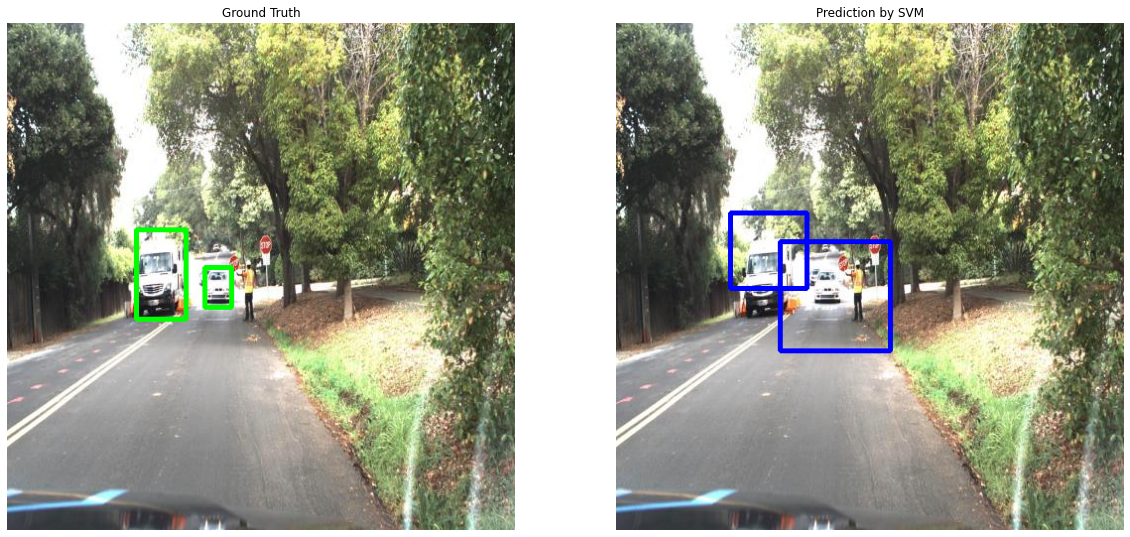

In [153]:
# Visualization 

test_ind = 149 # Use number between 0 to 999

tmp_img_id = img_id[test_ind]
tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[test_ind])), cv2.COLOR_BGR2RGB)
tmp_img2 = tmp_img.copy()
tmp_bbox = ann_bbox[(ann_img==test_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
tmp_bbox = tmp_bbox.astype(int)
            
for i in range(tmp_bbox.shape[0]):
    cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 

#pred_wind, tot_window_num = test_cascade.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
pred_wind, tot_window_num = searchMultiscale_tmp(tmp_img, test_cascade, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.3) # just for fp data generation

pred_wind = removeOverlap(pred_wind)

for i in range(pred_wind.shape[0]):
    cv2.rectangle(tmp_img2, (pred_wind[i,0], pred_wind[i,1]), (pred_wind[i,2], pred_wind[i,3]), (0, 0, 255), 4) 


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(tmp_img)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(122), plt.imshow(tmp_img2)
plt.title('Prediction by SVM')
plt.axis('off')

plt.show()

In [71]:
 def searchMultiscale_tmp(img, cascade, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
        """
        Returns the windows where the vehicles are found on the image
        Function for cascaded linearSVM with HOG descriptor 
        """ 
        wind_list = np.array([]).reshape(0,4)
        exp_scale = 1
        iter_num = 0 
        tot_window_num = 0
        while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
            windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
            # (xmin, ymin, xmax, ymax)
            tot_window_num += windows.shape[0]
            tmp_tot_img_window = np.array([]).reshape(0,64, 64, 3) 
            for ind in range(windows.shape[0]):
                img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (64, 64)) #CHANGE !
                tmp_tot_img_window = np.concatenate((tmp_tot_img_window, np.expand_dims(img_window, axis = 0)), axis = 0)
            
            pred = cascade.predict(tmp_tot_img_window)     
            if np.any(pred==1):
                wind_list = np.concatenate((wind_list, windows[pred == 1]), axis=0)
            
            exp_scale = scale*exp_scale
            iter_num+=1
            #if (iter_num>4):
            #    return wind_list, tot_window_num
        return wind_list, tot_window_num

In [73]:
# Final evaluation of cascaded hog classifier 
precision = []
recall = []
sensitivity = []
specificity = []
iou_matrix = []
Pred_iou = np.array([])
FP_img_lst = np.array([])


for val_ind in notebook.tqdm(range(0, 1000)):
    #Ground truth generation
    tmp_img_id = img_id[val_ind] 
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[val_ind])), cv2.COLOR_BGR2RGB)
    tmp_bbox = ann_bbox[(ann_img==val_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
    tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
    tmp_bbox = tmp_bbox.astype(int)
    
    #Prediction Generation
    #pred_wind, tot_window_num = test_cascade.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind, tot_window_num = searchMultiscale_tmp(tmp_img, test_cascade, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) # just for fp data generation
    pred_wind = removeOverlap(pred_wind)
    tmp_reduce_num = windowNumReducer(pred_wind)
    
    #Evaluation
    iou_matrix.append([tot_window_num-tmp_reduce_num, iouMatrix(tmp_bbox, pred_wind)])
    
    #TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
    #precision.append(zero_division(TP_cnt,(TP_cnt + FP_cnt)))
    #recall.append(zero_division(TP_cnt, (TP_cnt + FN_cnt)))
    #sensitivity.append(zero_division(TP_cnt,(TP_cnt + FN_cnt)))
    #specificity.append(zero_division(TN_cnt,(TN_cnt + FP_cnt)))
    #Pred_iou = np.concatenate((Pred_iou, tmp_iou), axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

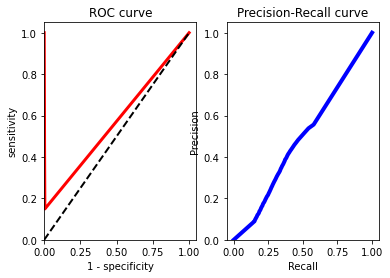

Average Precision: 48.7671%


In [87]:
averagePrec = drawROCnPrec(iou_matrix, step = 0.01)
print("Average Precision: {}%".format(np.round(averagePrec*100,4)))

# Section 3. Improving the algorithm

In [159]:
# import additional modules for improving algorithm 
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

알고리즘을 개선하기 위해, linearSVM 대신 gaussian kernal trick이 이용된 SVM을, 그리고 HOG feature 외에 rgb color histogram 및 local binary pattern histogram을 추가적으로 이용해줍니다. 

In [160]:
radius = 2
n_points = 8 * radius
METHOD = 'uniform'
n_bins = 18 #int(lbp.max() + 1)

def computeALLfeat(image):
    '''
    Compute feature of given image patch by concatenating HOG, LBP histogram, and color histogram 
    
    Input: [64,64,3] size image patch 
    Output: 1D feature vector of given image patch
    '''
    # INPUT : [64, 64, 3] size of image patch 
    rhist = np.histogram(image[:,:,0])
    ghist = np.histogram(image[:,:,1])
    bhist = np.histogram(image[:,:,2])

    # Concatenate
    color_hist = np.concatenate((rhist[0], ghist[0], bhist[0]))
 
    tmp_gray = cv2.cvtColor(np.float32(image), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(tmp_gray, n_points, radius, METHOD)
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, density=True) #앞의 것만 가져가면 돼 

    tmp_hog = descriptor.compute(cv2.resize(image.astype(np.uint8), (32,32)))
    #tmp_hog = calHog(cv2.resize(image.astype(np.uint8), (32,32))).astype(np.float64)
  
    tmp_feat = np.hstack((tmp_hog.ravel(), lbp_hist, color_hist))
    return tmp_feat

In [161]:
# Improved adaboost with combined features and kernal tricked support vector machine 
class Cas_AdaBoost2:
    def __init__(self, img_id, img_name, ann_bbox, ann_cat, ann_img):
        self.alphas = []
        self.G_M = []
        self.G_M_scaler = []
        self.M = len(self.G_M) #it is not updated interactively
        self.training_errors = []
        self.prediction_errors = []
        
        #Values of image
        self.img_id = img_id
        self.img_name = img_name
        self.ann_bbox = ann_bbox
        self.ann_cat = ann_cat
        self.ann_img = ann_img
        
        
    def LinSVM(self, X, y, w_i):
        '''
        block_set: [N,4] block sets
        X: [total_data_number, 64, 64, 3] patch of image
        y: labels of given data
        w_i: weight of training sample, updated base on adaboost algorithm 
        '''

        # Split up data into randomized training and test sets
        X_feat =  np.zeros((X.shape[0], 372))
        for i in range(X.shape[0]):
            X_feat[i, :] = computeALLfeat(X[i]).astype(np.float64)
            
        # Fit a per-column scaler
        tmp_scaler = StandardScaler().fit(X_feat)
                
        # Apply the scaler to X
        X_scaled = tmp_scaler.transform(X_feat) 
                  
        # Support Vector Machine Classifier
        # Convergence checkpoint & LinearSVM Training
        not_converged = 1
        max_iter_n = 15000
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            tmp_svm = SVC(kernel = 'rbf')
            tmp_svm.fit(X_scaled, y, sample_weight=w_i)

        tmp_svm_pred = tmp_svm.predict(X_scaled)
        return tmp_svm, tmp_svm_pred, tmp_scaler
    
    def searchMultiscale2(self, img, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
        """
        Returns the windows where the vehicles are found on the image
        """ 
        wind_list = np.array([]).reshape(0,4)
        exp_scale = 1
        iter_num = 0 
        tot_window_num = 0
        while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
            windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
            # (xmin, ymin, xmax, ymax)
            tot_window_num += windows.shape[0]
            tmp_tot_img_window = np.array([]).reshape(0,64, 64, 3) 
            for ind in range(windows.shape[0]):
                img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (64, 64)) #CHANGE !
                tmp_tot_img_window = np.concatenate((tmp_tot_img_window, np.expand_dims(img_window, axis = 0)), axis = 0)
            
            pred = self.predict(tmp_tot_img_window)
            if np.any(pred == 1):
                wind_list = np.concatenate((wind_list, windows[pred == 1]), axis=0)
    
            exp_scale = scale*exp_scale
            iter_num+=1
            if (iter_num>3):
                return wind_list, tot_window_num
        return wind_list, tot_window_num
    
    
    def updateF(self):
        '''
        calculate false detection rate FP/(TP+FP)
        '''
        false_detection = []
    
        #Select 500 random images to check model's false detection rate  
        random_val_ind = random.sample(range(1000, len(self.img_id)), 50)
        for val_ind in random_val_ind:
            #Ground truth generation
            tmp_img_id = self.img_id[val_ind] 
            tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',self.img_name[val_ind])), cv2.COLOR_BGR2RGB)
            tmp_bbox = self.ann_bbox[(self.ann_img==val_ind)*((self.ann_cat==2) +(self.ann_cat==11))] # N*4
            tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
            tmp_bbox = tmp_bbox.astype(int)
            
            #Prediction Generation
            pred_wind, tot_window_num = self.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
            pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) #0.3~0.5
            pred_wind = removeOverlap(pred_wind)
            
            #Evaluation
            TP_cnt, FP_cnt, FN_cnt, FP, tmp_iou = detectFP(tmp_bbox, pred_wind, iou_th = 0.5)
            false_detection.append(zero_division(FP_cnt, (TP_cnt + FP_cnt)))

        fd_rate  = np.mean(false_detection)
        return fd_rate
    
    def trainAcc(self, X, y):
        '''
        calculate and return current accuracy on training data
        '''
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y)/len(y)
        return accuracy
    
    def fit(self, X, y, target_Acc):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        f_max: predefined false discovery rate (instead of false-positive rate)
        '''
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        curr_f = 1.0 # FP/(TP+FP)
        m = 0
        curr_Acc = 0
        Acc_history = []
        # Iterate over M weak classifiers
        #while (curr_f > f_max):
        while (curr_Acc < target_Acc):
            print("Training {}_th weak classifier, current train accuracy: {}".format(m, round(curr_Acc, 4)), end='')
            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y) * len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = update_weights(w_i, alpha_m, y, y_pred) * len(y)
            
            # (a) Fit weak classifier and predict labels
            G_m, y_pred, G_scaler = self.LinSVM(X, y, w_i)

            self.G_M.append(G_m) # Save to list of weak classifiers
            self.G_M_scaler.append(G_scaler)
            
            # (b) Compute error
            error_m = compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
            
            # update threshold values
            curr_Acc = self.trainAcc(X, y)

            if ((curr_Acc > 0.9999) or (curr_Acc > target_Acc)):
                curr_f = self.updateF()
                print(", False detection rate: {}".format(round(curr_f, 4)))
            else:
                print("")
            m = m + 1 
            
            #If learning is saturated go to next cascade layer 
            Acc_history.append(curr_Acc)
            if ((len(Acc_history) > 4)):
                hist_grad = np.gradient(Acc_history)   
                if (np.all(np.sign(hist_grad[-3:]) <=0)):
                    break
        assert len(self.G_M) == len(self.alphas)
        print("Cascade Generated!")
        return curr_Acc, curr_f
        
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like (k image sets)
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(len(self.G_M))) 
        
        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(len(self.G_M)):             
            tmp_scaler = self.G_M_scaler[m]
            X_feat = np.zeros((X.shape[0], 372))
            for j in range(X.shape[0]):
                X_feat[j, :] = computeALLfeat(X[j,:,:,:]).astype(np.float64)
                
            # Apply the scaler to X
            X_scaled = tmp_scaler.transform(X_feat) 
            y_pred_m = self.G_M[m].predict(X_scaled) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
            
        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred

In [162]:
# Improved cascade pipeline 
class Casade_pipeline2:
    def __init__(self, img_id, img_name, ann_bbox, ann_cat, ann_img):
        self.cascade = []
        self.level = len(self.cascade)
        
        #Values of image
        self.img_id = img_id
        self.img_name = img_name
        self.ann_bbox = ann_bbox
        self.ann_cat = ann_cat
        self.ann_img = ann_img
    
    def searchMultiscale2(self, img, xy_window=(64, 64), overlap_ratio=(0.5, 0.5), scale = 1.2):
        """
        Returns the windows where the vehicles are found on the image
        """ 
        wind_list = np.array([]).reshape(0,4)
        exp_scale = 1
        iter_num = 0 
        tot_window_num = 0
        while (img.shape[0]*3/4 > xy_window[0]*exp_scale):                                       
            windows = SlidingWindow(img, xy_window=xy_window, overlap_ratio=overlap_ratio, scale = exp_scale)
            # (xmin, ymin, xmax, ymax)
            tot_window_num += windows.shape[0]
            tmp_tot_img_window = np.array([]).reshape(0,64, 64, 3) 
            for ind in range(windows.shape[0]):
                img_window = cv2.resize(img[windows[ind,1]:windows[ind,3], windows[ind,0]:windows[ind,2]], (64, 64)) #CHANGE !
                tmp_tot_img_window = np.concatenate((tmp_tot_img_window, np.expand_dims(img_window, axis = 0)), axis = 0)
            
            pred = self.predict(tmp_tot_img_window)     
            if np.any(pred==1):
                wind_list = np.concatenate((wind_list, windows[pred == 1]), axis=0)
            
            exp_scale = scale*exp_scale
            iter_num+=1
            #if (iter_num>4):
            #    return wind_list, tot_window_num
        return wind_list, tot_window_num
    
    def updateNeg(self, num_positive):
        '''
         Get new Negative datasets for training
        '''
        
        train_neg_patch = np.array([]).reshape(0, 64, 64, 3)
        #Select 500 random images to check model's false detection rate  
        random_val_ind = random.sample(range(1000, len(self.img_id)), 3500)
        for val_ind in notebook.tqdm(random_val_ind):
            #Ground truth generation
            tmp_img_id = self.img_id[val_ind] 
            tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',self.img_name[val_ind])), cv2.COLOR_BGR2RGB)
            tmp_bbox = self.ann_bbox[(self.ann_img==val_ind)*((self.ann_cat==2) +(self.ann_cat==11))] # N*4
            tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
            tmp_bbox = tmp_bbox.astype(int)
            
            #Prediction Generation
            pred_wind, tot_window_num = self.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
            pred_wind = NonMaxSup(pred_wind, overlapThresh = 1.5) # just for fp data generation
            
            #Evaluation
            TP_cnt, FP_cnt, FN_cnt, FP, tmp_iou = detectFP(tmp_bbox, pred_wind, iou_th = 0.5)
            
            for i in range(FP.shape[0]):
                tmp_fp = cv2.resize(tmp_img[FP[i,1]:FP[i,3],FP[i,0]:FP[i,2]], (64,64))
                train_neg_patch = np.concatenate((train_neg_patch, np.expand_dims(tmp_fp, axis=0)), axis=0)
                if (train_neg_patch.shape[0] >= 1*num_positive): #################################################바꿔 필요시
                    return train_neg_patch
            
        return train_neg_patch
    
    def fit(self, X_pos, y_pos, X_neg, y_neg, target_Acc = 0.98, F_target = 0.5, accDecay = 0.98):
        F_curr = 1.0
        X = np.concatenate((X_pos, X_neg), axis =0).astype(np.float64)        
        y = np.hstack((np.ones(X_pos.shape[0]), -np.ones(X_neg.shape[0])))
        cascade_level = 0
        level_target_acc = target_Acc
        
        while (F_curr > F_target):
            print("*******Current cascade level: {} / Expected false detection rate : {}".format(cascade_level, round(F_curr,4)))
            tmp_cascade = Cas_AdaBoost2(self.img_id, self.img_name, self.ann_bbox, self.ann_cat, self.ann_img)
            curr_Acc, curr_f = tmp_cascade.fit(X, y, target_Acc = level_target_acc)
            self.cascade.append(tmp_cascade)
            
            # Making new negative dataset for next cascade
            X_neg = self.updateNeg(X_pos.shape[0])
            X = np.concatenate((X_pos, X_neg), axis =0).astype(np.float64)        
            y = np.hstack((np.ones(X_pos.shape[0]), -np.ones(X_neg.shape[0])))
            
            # Updating False detection rate 
            F_curr = F_curr*curr_f
            cascade_level +=1
            level_target_acc = level_target_acc*accDecay
            
        print('Training Done !!')
    
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like (k image sets - 4 Dimensional image sets) [N, 64, 64, 3]
        '''
        # Predict class label for each weak classifier, weighted by alpha_m
        final_cas_predict = np.ones(X.shape[0])
        X_casind = np.argwhere(final_cas_predict==1).ravel()
        X_origin = X.copy()
        for lv in range(len(self.cascade)):
            curr_cascade = self.cascade[lv]
            curr_predict = curr_cascade.predict(X) # [N] +1 or -1 // 이미 짧아진 것 
            tmp_curr_predict = -np.ones(len(final_cas_predict))
            tmp_curr_predict[X_casind] = curr_predict
            
            #final_cas_predict = np.min(np.vstack((final_cas_predict, tmp_curr_predict)), axis =0) 
            final_cas_predict = tmp_curr_predict
            if np.all(final_cas_predict == -1):
                return final_cas_predict
            
            #update X 
            X_casind = np.argwhere(final_cas_predict==1).ravel()
            X = X_origin[X_casind]

        
        return final_cas_predict

만들어진 알고리즘을 바탕으로 새로운 cascade를 학습시킵니다.

In [ ]:
#CASCADE_DETECTOR2 = Casade_pipeline2(img_id, img_name, ann_bbox, ann_cat, ann_img)
#CASCADE_DETECTOR2.fit(X_pos = pos_batch, 
#             y_pos = np.ones(pos_batch.shape[0]), 
#             X_neg = neg_batch, 
#             y_neg = -np.ones(neg_batch.shape[0]), 
#             F_target = 0.25,
#             target_Acc = 0.99,
#             accDecay = 0.99)

전에 학습된 classifier를 불러옵니다. 

In [163]:
with open("pickle/rbf_cascaded_classifier_2.pickle","rb") as f:
    test_cascade = pickle.load(f)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(-0.5, 511.5, 511.5, -0.5)

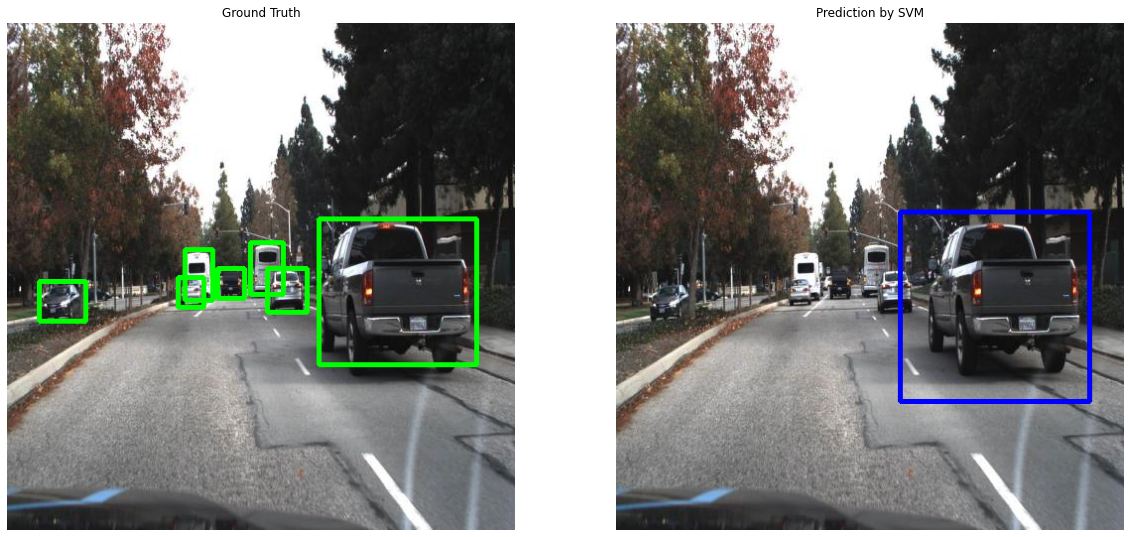

In [164]:
#VISUALIZATION
test_ind = 24 # Use number between 0 to 999

tmp_img_id = img_id[test_ind]
tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[test_ind])), cv2.COLOR_BGR2RGB)
tmp_img2 = tmp_img.copy()
tmp_bbox = ann_bbox[(ann_img==test_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
tmp_bbox = tmp_bbox.astype(int)
            
for i in range(tmp_bbox.shape[0]):
    cv2.rectangle(tmp_img, (tmp_bbox[i,0], tmp_bbox[i,1]), (tmp_bbox[i,2]+1, tmp_bbox[i,3]), (0, 255, 0), 4) 

pred_wind, tot_window_num = test_cascade.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.3) # just for fp data generation

pred_wind = removeOverlap(pred_wind)

for i in range(pred_wind.shape[0]):
    cv2.rectangle(tmp_img2, (pred_wind[i,0], pred_wind[i,1]), (pred_wind[i,2], pred_wind[i,3]), (0, 0, 255), 4) 


plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(tmp_img)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(122), plt.imshow(tmp_img2)
plt.title('Prediction by SVM')
plt.axis('off')


In [165]:
#FINAL EVALUATION
precision = []
recall = []
sensitivity = []
specificity = []
iou_matrix = []
Pred_iou = np.array([])
FP_img_lst = np.array([])

for val_ind in notebook.tqdm(range(0, 1000)):
    #Ground truth generation
    tmp_img_id = img_id[val_ind] 
    tmp_img = cv2.cvtColor(cv2.imread(os.path.join('Self Driving Car.v3-fixed-small.coco/export',img_name[val_ind])), cv2.COLOR_BGR2RGB)
    tmp_bbox = ann_bbox[(ann_img==val_ind)*((ann_cat==2) +(ann_cat==11))] # N*4
    tmp_bbox[:, 2:] = tmp_bbox[:, :2] + np.round(tmp_bbox[:, 2:]) #(xmin, ymin. xmax. ymax)
    tmp_bbox = tmp_bbox.astype(int)
    
    #Prediction Generation
    pred_wind, tot_window_num = test_cascade.searchMultiscale2(tmp_img, xy_window=(64,64), overlap_ratio=(0.5, 0.5), scale = 1.2)
    pred_wind = NonMaxSup(pred_wind, overlapThresh = 0.5) # just for fp data generation
    pred_wind = removeOverlap(pred_wind)
    tmp_reduce_num = windowNumReducer(pred_wind)

    #Evaluation
    iou_matrix.append([tot_window_num - tmp_reduce_num, iouMatrix(tmp_bbox, pred_wind)])
    
    #TN_cnt = tot_window_num - TP_cnt - FP_cnt - FN_cnt
    #precision.append(zero_division(TP_cnt,(TP_cnt + FP_cnt)))
    #recall.append(zero_division(TP_cnt, (TP_cnt + FN_cnt)))
    #sensitivity.append(zero_division(TP_cnt,(TP_cnt + FN_cnt)))
    #specificity.append(zero_division(TN_cnt,(TN_cnt + FP_cnt)))
    #Pred_iou = np.concatenate((Pred_iou, tmp_iou), axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

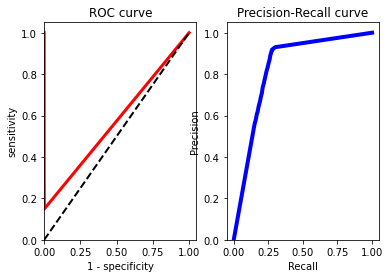

Average Precision: 83.2646%


In [166]:
averagePrec = drawROCnPrec(iou_matrix, step = 0.01)
print("Average Precision: {}%".format(np.round(averagePrec*100,4)))